### 

## ESM to predict variability
Another important assessment of the protein was the mutability of its positions. To address this, an ESM (Evolutionary Scale Modeling) language model was implemented. This analyses can be done without using any database search or sequence alignment.

Once the analysis was done and the embeddings were generated, the first idea was to show that two similar residues in a different environment will have different representations. Basically, we are showing that it is not only the properties of the amino acid but also the interactions it has with its surroundings that define the grouping of the different positions.

Another important aspect was variability of a position as a whole. Entropy is a measure that quantifies the uncertainty or randomness associated with a random variable. So, by calculating the entropy using the probabilities of all mutations at a specific position, we obtained a single value that quantifies the overall uncertainty or randomness associated with that position.

### Installing the dependencies

In [74]:
import torch
import esm
import pandas as pd

# Load ESM-1b model
model, alphabet = esm.pretrained.esm1_t6_43M_UR50S()
batch_converter = alphabet.get_batch_converter()

In [56]:
RBD=[["RDB", 'MATKAVCVLKGDGPVQGIINFEQKESNGPVKVWGSIKGLTEGLHGFHVHEFGDNTAGCTSAGPHFNPLSRKHGGPKDEERHVGDLGNVTADKDGVADVSIEDSVISLSGDHCIIGRTLVVHEKADDLGKGGNEESTKTGNAGSRLACGVIGIAQ']]
print(len('MATKAVCVLKGDGPVQGIINFEQKESNGPVKVWGSIKGLTEGLHGFHVHEFGDNTAGCTSAGPHFNPLSRKHGGPKDEERHVGDLGNVTADKDGVADVSIEDSVISLSGDHCIIGRTLVVHEKADDLGKGGNEESTKTGNAGSRLACGVIGIAQ'))
batch_labels, batch_strs, batch_tokens = batch_converter(RBD)

with torch.no_grad():
  results = model(batch_tokens, repr_layers=[6], return_contacts=False)


154


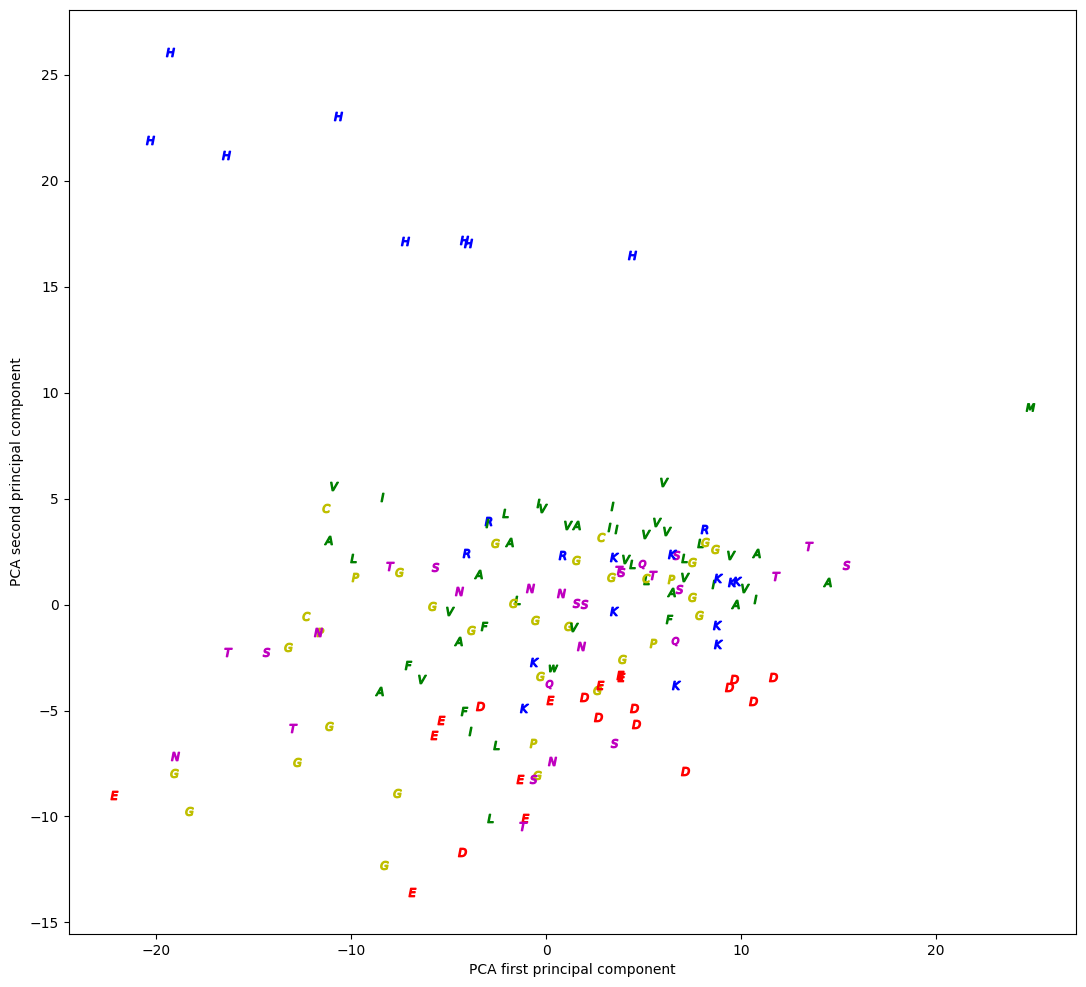

In [75]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

Xs = results['representations'][6].numpy()
Xs= np.squeeze(Xs)
Xs=Xs[1:,]
labels = batch_tokens[0,1:]
pca = PCA(3)
Xs_train_pca = pca.fit_transform(Xs)
fig_dims = (13, 12)
fig, ax = plt.subplots(figsize=fig_dims)
sco=[]
colors={'A':'g',
        'C':'y',
        'D':'r',
        'E':'r',
        'F':'g',
        'G':'y',
        'H':'b',
        'I':'g',
        'K':'b',
        'L':'g',
        'M':'g',
        'N':'m',
        'P':'y',
        'Q':'m',
        'R':'b',
        'S':'m',
        'T':'m',
        'V':'g',
        'W':'g',
        'Y':'m'}
for amino in alphabet.all_toks[4:24]:
  index_amino =  alphabet.all_toks.index( amino)
  amino_index = [j for j in range(Xs.shape[0]) if labels[j]==index_amino]
  sco.append( ax.scatter(Xs_train_pca[amino_index,0], Xs_train_pca[amino_index,1],  marker='$'+amino+'$',c=colors[amino]))


ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.show()

# Save the PCA plot in png format
fig.savefig('PCA_plot.png', dpi=300)

Let's now use the LM to predict potential variant sites. The LM have been trained to predict the masked amino acids in a sequence. We can interpret the output probabilities as a proxy for the "mutability" of each site. Let's first define a function to get the probabilities from the model

In [76]:
def logit_to_prob(logitList):
  import torch.nn.functional as nnf

  prob = nnf.softmax(logitList, dim=1)

  top_p, top_class = prob.topk(1, dim = 1)
  return(prob,top_p,top_class)


Extract the probability of each amino acid at each position

In [77]:
probs,top_p,top_class=logit_to_prob(results['logits'][0])
len(probs)

155

If we select, at each position, the amino acid with the highest probability, we get a reconstructed sequence.

In [80]:
reconstructed[1:]
# Remove 0 from reconstructed
reconstructed=reconstructed[1:]

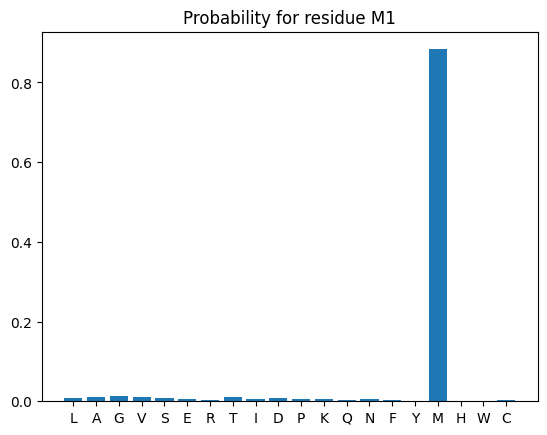

In [82]:
residueId = 1


residue =  RBD[0][1][residueId-1]
probRes = probs[residueId]


import matplotlib.pyplot as plt
 


for i in range(4,24):
   plotdata ={alphabet.unique_no_split_tokens[j] : probRes[j] for j in range(4,24)}


plt.bar(plotdata.keys(),plotdata.values())
plt.title("Probability for residue "+residue+str(residueId))
plt.show()

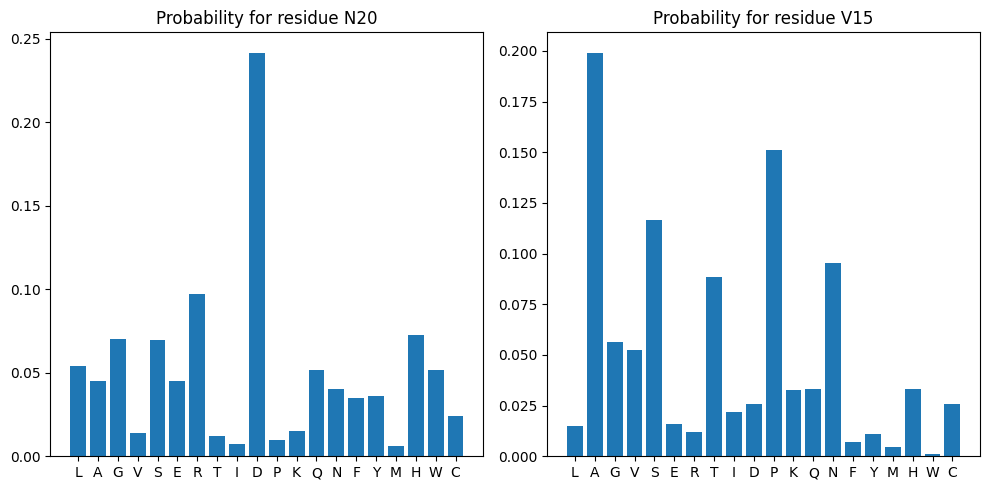

In [83]:
import matplotlib.pyplot as plt

residueIds = [20, 15]

# Create a new figure
bar_plot = plt.figure(figsize=(10, 5))

for index, residueId in enumerate(residueIds):
    residue = RBD[0][1][residueId-1]
    probRes = probs[residueId]

    plotdata = {alphabet.unique_no_split_tokens[j] : probRes[j] for j in range(4,24)}

    # Create a new subplot for each residue
    plt.subplot(1, len(residueIds), index + 1)
    plt.bar(plotdata.keys(), plotdata.values())
    plt.title("Probability for residue " + residue + str(residueId))

# Show the figure with all subplots
plt.tight_layout()
plt.show()

# Save the bar plot for this in png format
bar_plot.savefig('bar_plot.png', dpi=300)

In [84]:
# I want to make a datafram where I have position, residue, and probability
# Create a list of dictionaries
data = []
for residueId in range(1, len(RBD[0][1]) + 1):
    residue = RBD[0][1][residueId-1]
    probRes = probs[residueId]

    for index, amino in enumerate(alphabet.all_toks[4:24]):
        data.append({
            'position': residueId,
            'residue': amino,
            'probability': probRes[index].item()
        })

data

[{'position': 1, 'residue': 'L', 'probability': 3.2869433811255427e-24},
 {'position': 1, 'residue': 'A', 'probability': 1.016144452397282e-24},
 {'position': 1, 'residue': 'G', 'probability': 1.8582833468274973e-24},
 {'position': 1, 'residue': 'V', 'probability': 6.100911697282826e-25},
 {'position': 1, 'residue': 'S', 'probability': 0.009286976419389248},
 {'position': 1, 'residue': 'E', 'probability': 0.011030287481844425},
 {'position': 1, 'residue': 'R', 'probability': 0.014397229067981243},
 {'position': 1, 'residue': 'T', 'probability': 0.010205678641796112},
 {'position': 1, 'residue': 'I', 'probability': 0.008164682425558567},
 {'position': 1, 'residue': 'D', 'probability': 0.006887282710522413},
 {'position': 1, 'residue': 'P', 'probability': 0.0034574244637042284},
 {'position': 1, 'residue': 'K', 'probability': 0.009541522711515427},
 {'position': 1, 'residue': 'Q', 'probability': 0.005684054456651211},
 {'position': 1, 'residue': 'N', 'probability': 0.006986828055232763},

In [85]:
# Write the data to a pandas DataFrame
df1 = pd.DataFrame(data)
df1.head(15)

,position,residue,probability
0,1,L,3.286943e-24
1,1,A,1.016144e-24
2,1,G,1.858283e-24
3,1,V,6.100912e-25
4,1,S,9.286976e-03
5,1,E,1.103029e-02
6,1,R,1.439723e-02
7,1,T,1.020568e-02
8,1,I,8.164682e-03
9,1,D,6.887283e-03


In [65]:
# Write df1 to a tsv file with the three columns: Position, Residue, Probability
df1.to_csv('residue_probabilities.tsv', sep='\t', index=False)

### Entropy
With all the amino acid probabilities for each position, we can calculate the entropy, which its a number that indicates the total variability (mutability) in each position.

In [91]:
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Calculate entropy for each position
entropies = [entropy(probs[i]) for i in range(len(probs))]

# Create a dataframe with position and entropy columns
df = pd.DataFrame({'Position': range(1, len(entropies) + 1), 'Entropy': entropies})
df = df[df['Position'] != 1]


# Display the dataframe
print(df.head(15))

# Print 154 value of entropy
print(df.loc[df['Position'] == 156])


    Position   Entropy
1          2  0.686451
2          3  2.387989
3          4  2.723504
4          5  2.556525
5          6  2.478653
6          7  2.754339
7          8  2.257037
8          9  2.646506
9         10  2.687295
10        11  2.827472
11        12  2.523831
12        13  2.124481
13        14  2.805852
14        15  2.641597
15        16  2.527293
Empty DataFrame
Columns: [Position, Entropy]
Index: []


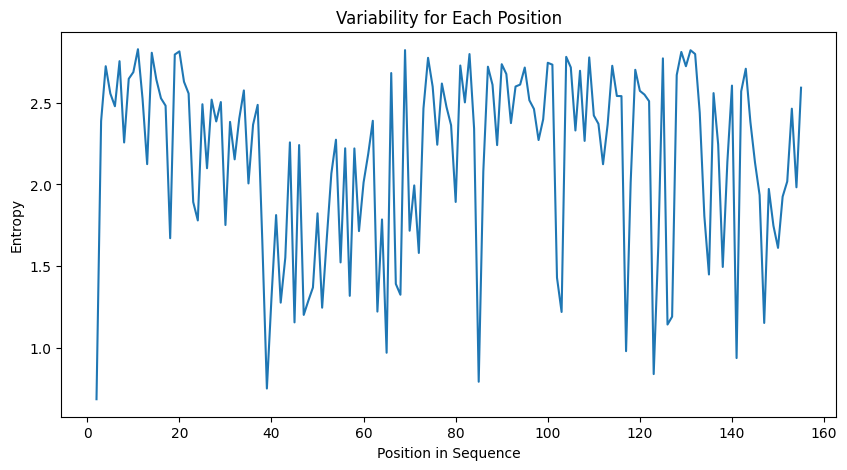

In [93]:
plt.figure(figsize=(10, 5))
plt.plot(df['Position'], df['Entropy'])
plt.xlabel('Position in Sequence')
plt.ylabel('Entropy')
plt.title('Variability for Each Position')
plt.show()


In [92]:
# Get the 10 highest and 10 lowest values
highest_values = df.nlargest(10, 'Entropy')
lowest_values = df.nsmallest(10, 'Entropy')

# Print the highest and lowest value tables
print("Highest Values:")
print(highest_values)

print("\nLowest Values:")
print(lowest_values)

print(len(entropies))

# Write the highest and lowest value tables to a single tsv file
highest_values.to_csv('highest_entropy.tsv', sep='\t', index=False)
lowest_values.to_csv('lowest_entropy.tsv', sep='\t', index=False)


Highest Values:
     Position   Entropy
10         11  2.827472
68         69  2.821940
130       131  2.821204
19         20  2.814337
128       129  2.810883
13         14  2.805852
131       132  2.798042
82         83  2.797862
18         19  2.794951
103       104  2.780766

Lowest Values:
     Position   Entropy
1           2  0.686451
38         39  0.751868
84         85  0.793318
122       123  0.840259
140       141  0.938283
64         65  0.970740
116       117  0.980435
125       126  1.143366
146       147  1.152967
44         45  1.156474
155


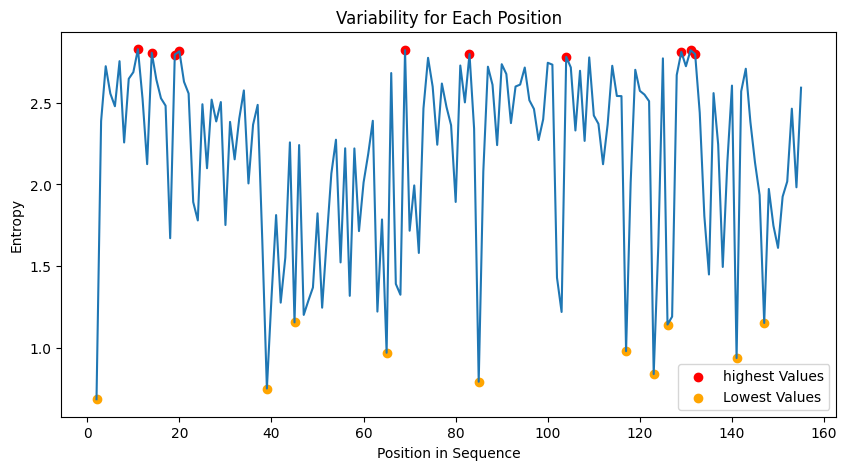

In [94]:
# Plot entropy

entropy_plot = plt.figure(figsize=(10, 5))
plt.plot(df['Position'], df['Entropy'])
plt.scatter(highest_values['Position'], highest_values['Entropy'], color='red', label='highest Values')
plt.scatter(lowest_values['Position'], lowest_values['Entropy'], color='orange', label='Lowest Values')
plt.xlabel('Position in Sequence')
plt.ylabel('Entropy')
plt.title('Variability for Each Position')
plt.legend()
plt.show()

# Save the entropy plot in png format
entropy_plot.savefig('entropy_plot.png', dpi=300)

### Significant test
See which positions are statistically very mutable or little mutable.

In [70]:
# entropies is a list of calculated entropy scores for each position

# Define a function to calculate the test statistic
def test_statistic(group1, group2):
    # Calculate the difference in means between the two groups
    return np.mean(group1) - np.mean(group2)

# Define the number of permutations
num_permutations = 1000

# Initialize an array to store the permutation p-values
p_values = np.zeros(len(entropies))

# Perform the permutation test for each position
for i in range(len(entropies)):
    # Create a combined array of entropy scores for all positions
    combined = np.array(entropies)
    
    # Permute the combined array
    np.random.shuffle(combined)
    
    # Split the permuted array into two groups
    group1 = combined[:i+1]
    group2 = combined[i+1:]
    
    # Calculate the test statistic for the permuted groups
    permuted_statistic = test_statistic(group1, group2)
    
    # Calculate the p-value as the proportion of permuted test statistics greater than the observed test statistic
    p_value = np.sum(permuted_statistic >= test_statistic(entropies[:i+1], entropies[i+1:])) / num_permutations
    
    # Store the p-value for the position
    p_values[i] = p_value

# Print the p-values for each position
for i, p_value in enumerate(p_values):
    print("Position", i+1, "p-value:", p_value)


Position 1 p-value: 0.0
Position 2 p-value: 0.001
Position 3 p-value: 0.001
Position 4 p-value: 0.001
Position 5 p-value: 0.001
Position 6 p-value: 0.0
Position 7 p-value: 0.001
Position 8 p-value: 0.001
Position 9 p-value: 0.0
Position 10 p-value: 0.0
Position 11 p-value: 0.001
Position 12 p-value: 0.0
Position 13 p-value: 0.001
Position 14 p-value: 0.0
Position 15 p-value: 0.0
Position 16 p-value: 0.0
Position 17 p-value: 0.0
Position 18 p-value: 0.001
Position 19 p-value: 0.0
Position 20 p-value: 0.0
Position 21 p-value: 0.0
Position 22 p-value: 0.0
Position 23 p-value: 0.0
Position 24 p-value: 0.0
Position 25 p-value: 0.0
Position 26 p-value: 0.0
Position 27 p-value: 0.0
Position 28 p-value: 0.0
Position 29 p-value: 0.0
Position 30 p-value: 0.0
Position 31 p-value: 0.0
Position 32 p-value: 0.0
Position 33 p-value: 0.0
Position 34 p-value: 0.0
Position 35 p-value: 0.0
Position 36 p-value: 0.0
Position 37 p-value: 0.0
Position 38 p-value: 0.0
Position 39 p-value: 0.0
Position 40 p-va

/home/jaime/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jaime/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/jaime/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [71]:
# Write entropies to a tsv file
df.to_csv('entropies.tsv', sep='\t', index=False)

### Conclusion
There are positions in the protein that have higher variability. In proxy this could be a strong indicator of the mutability of some of the positions in the protein. In addition, it also suggest which position are more conserved.